<a href="https://colab.research.google.com/github/SANKARM18/computer-vision/blob/main/lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ Using device: cuda


🎬 STARTING ENHANCED PROFESSIONAL ADAS DEMO

✓ Video file found: /content/5382495-uhd_3840_2160_24fps.mp4

🚗 ENHANCED PROFESSIONAL ADAS SYSTEM INITIALIZATION
✓ Glare mitigation loaded
✓ Lane detector loaded
⏳ Loading object detection model...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 205MB/s]


✓ Object detection ready

✅ ALL SYSTEMS READY!

📹 Video Information:
   Path: /content/5382495-uhd_3840_2160_24fps.mp4
   Resolution: 3840x2160
   FPS: 24
   Total frames: 818
   Processing: 300 frames

🔄 Processing video frames...
────────────────────────────────────────────────────────────────────────────────
   ⏳ Progress: 25/300 frames (8.3%) | Lanes: 25 | Peds: 0 | Vehicles: 131 | Signs: 12
   ⏳ Progress: 50/300 frames (16.7%) | Lanes: 50 | Peds: 0 | Vehicles: 269 | Signs: 16
   ⏳ Progress: 75/300 frames (25.0%) | Lanes: 75 | Peds: 6 | Vehicles: 363 | Signs: 17
   ⏳ Progress: 100/300 frames (33.3%) | Lanes: 100 | Peds: 7 | Vehicles: 491 | Signs: 17
   ⏳ Progress: 125/300 frames (41.7%) | Lanes: 125 | Peds: 7 | Vehicles: 597 | Signs: 17
   ⏳ Progress: 150/300 frames (50.0%) | Lanes: 150 | Peds: 7 | Vehicles: 736 | Signs: 17
   ⏳ Progress: 175/300 frames (58.3%) | Lanes: 175 | Peds: 8 | Vehicles: 878 | Signs: 17
   ⏳ Progress: 200/300 frames (66.7%) | Lanes: 200 | Peds: 8 | Vehicles

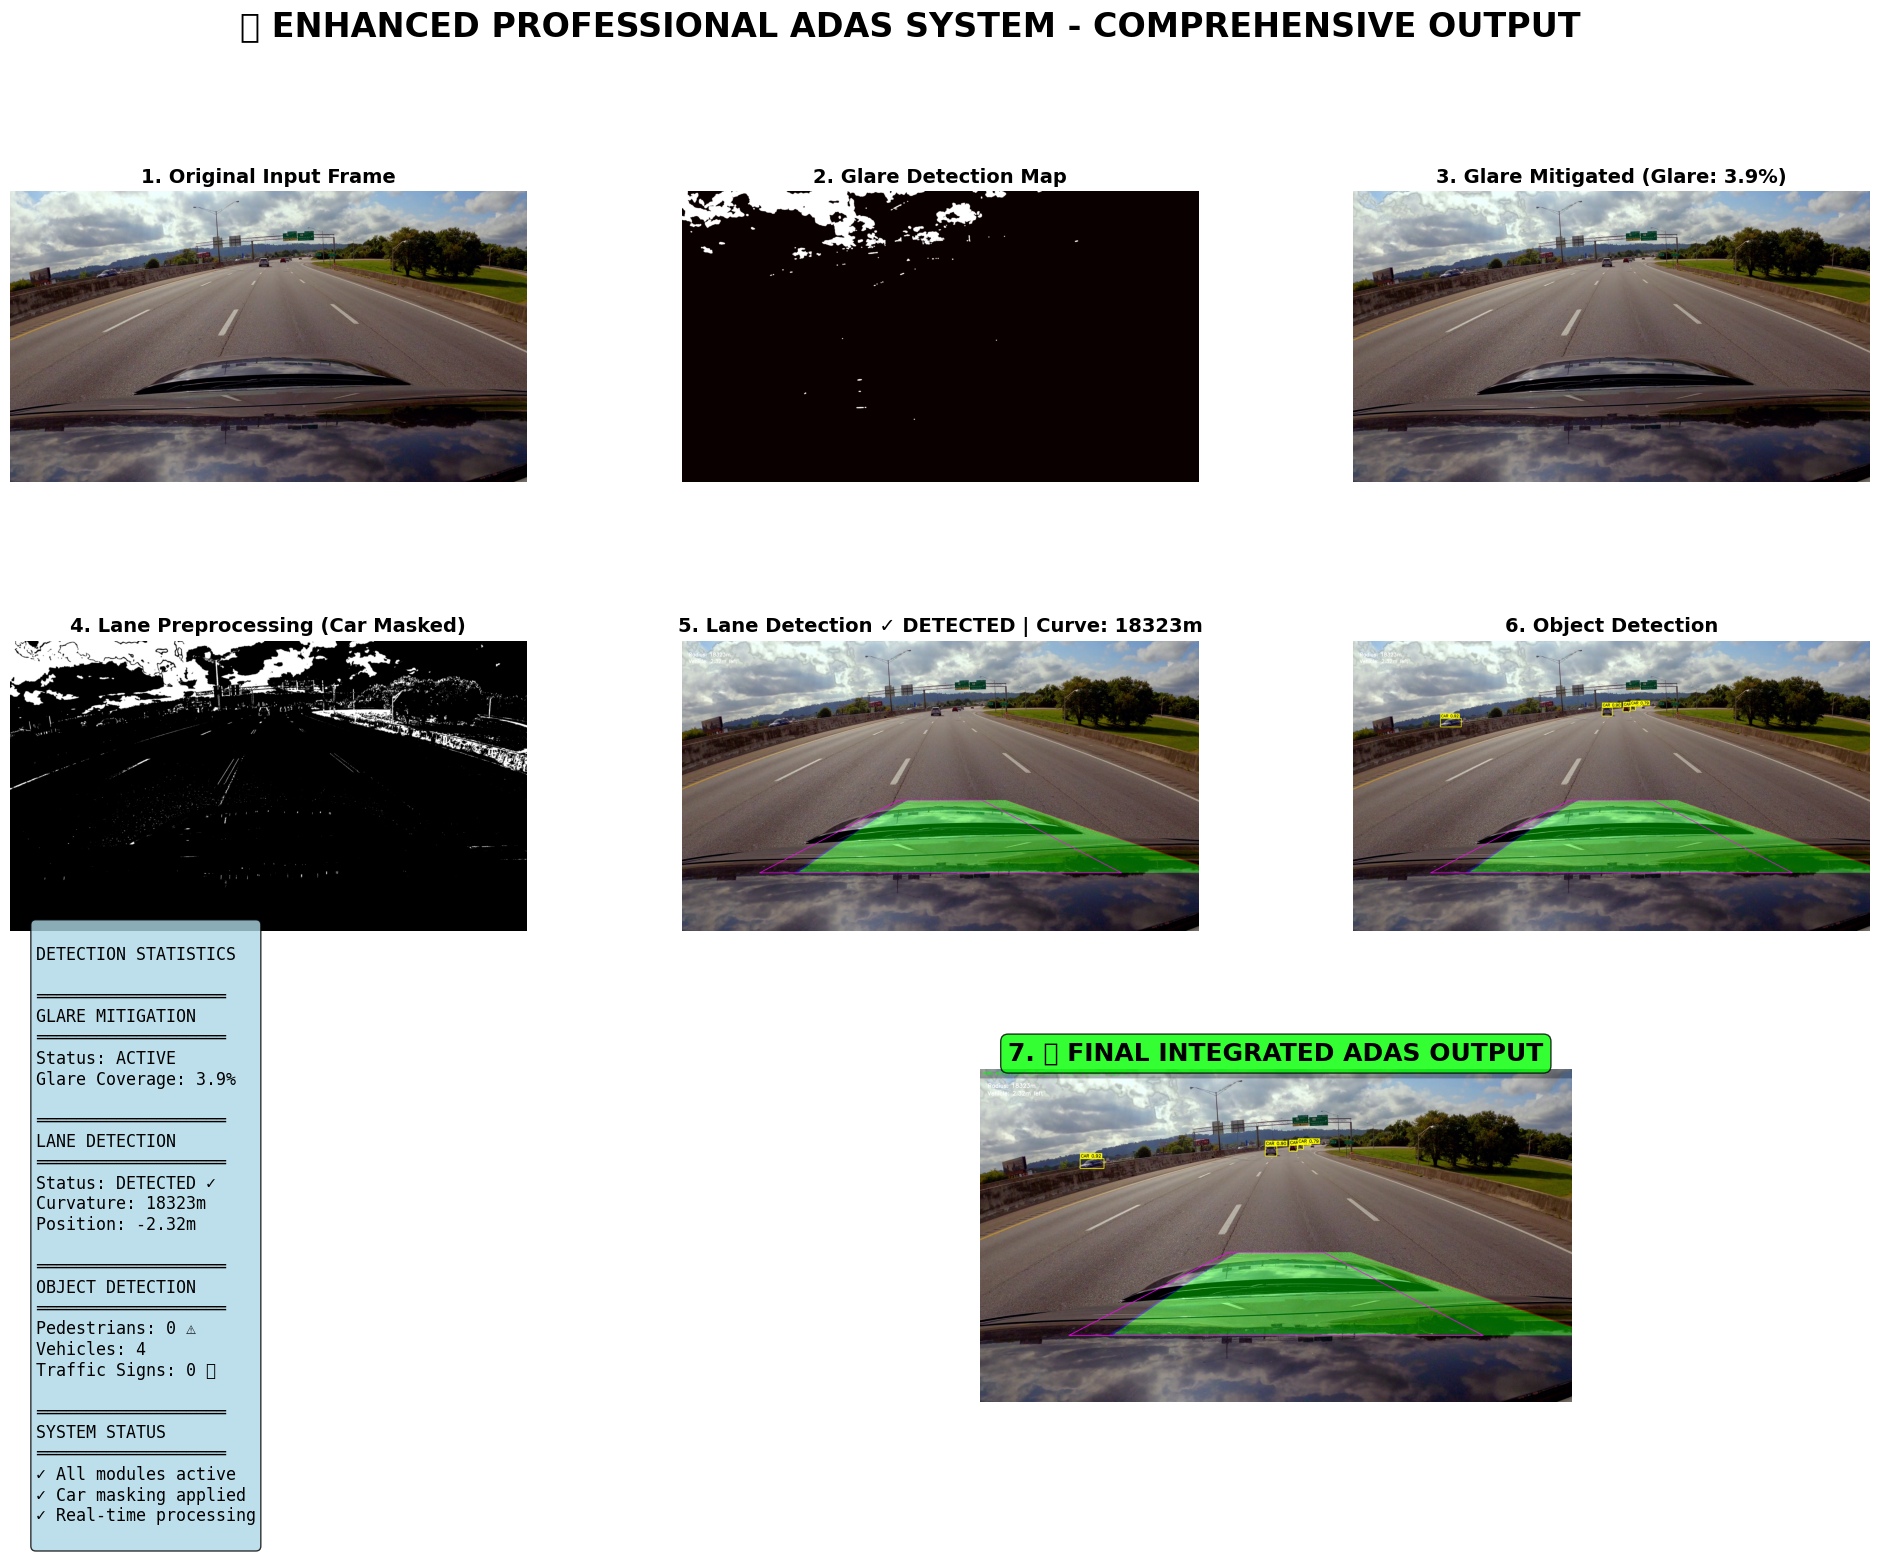



Showcase Frame 2 (Frame #60):


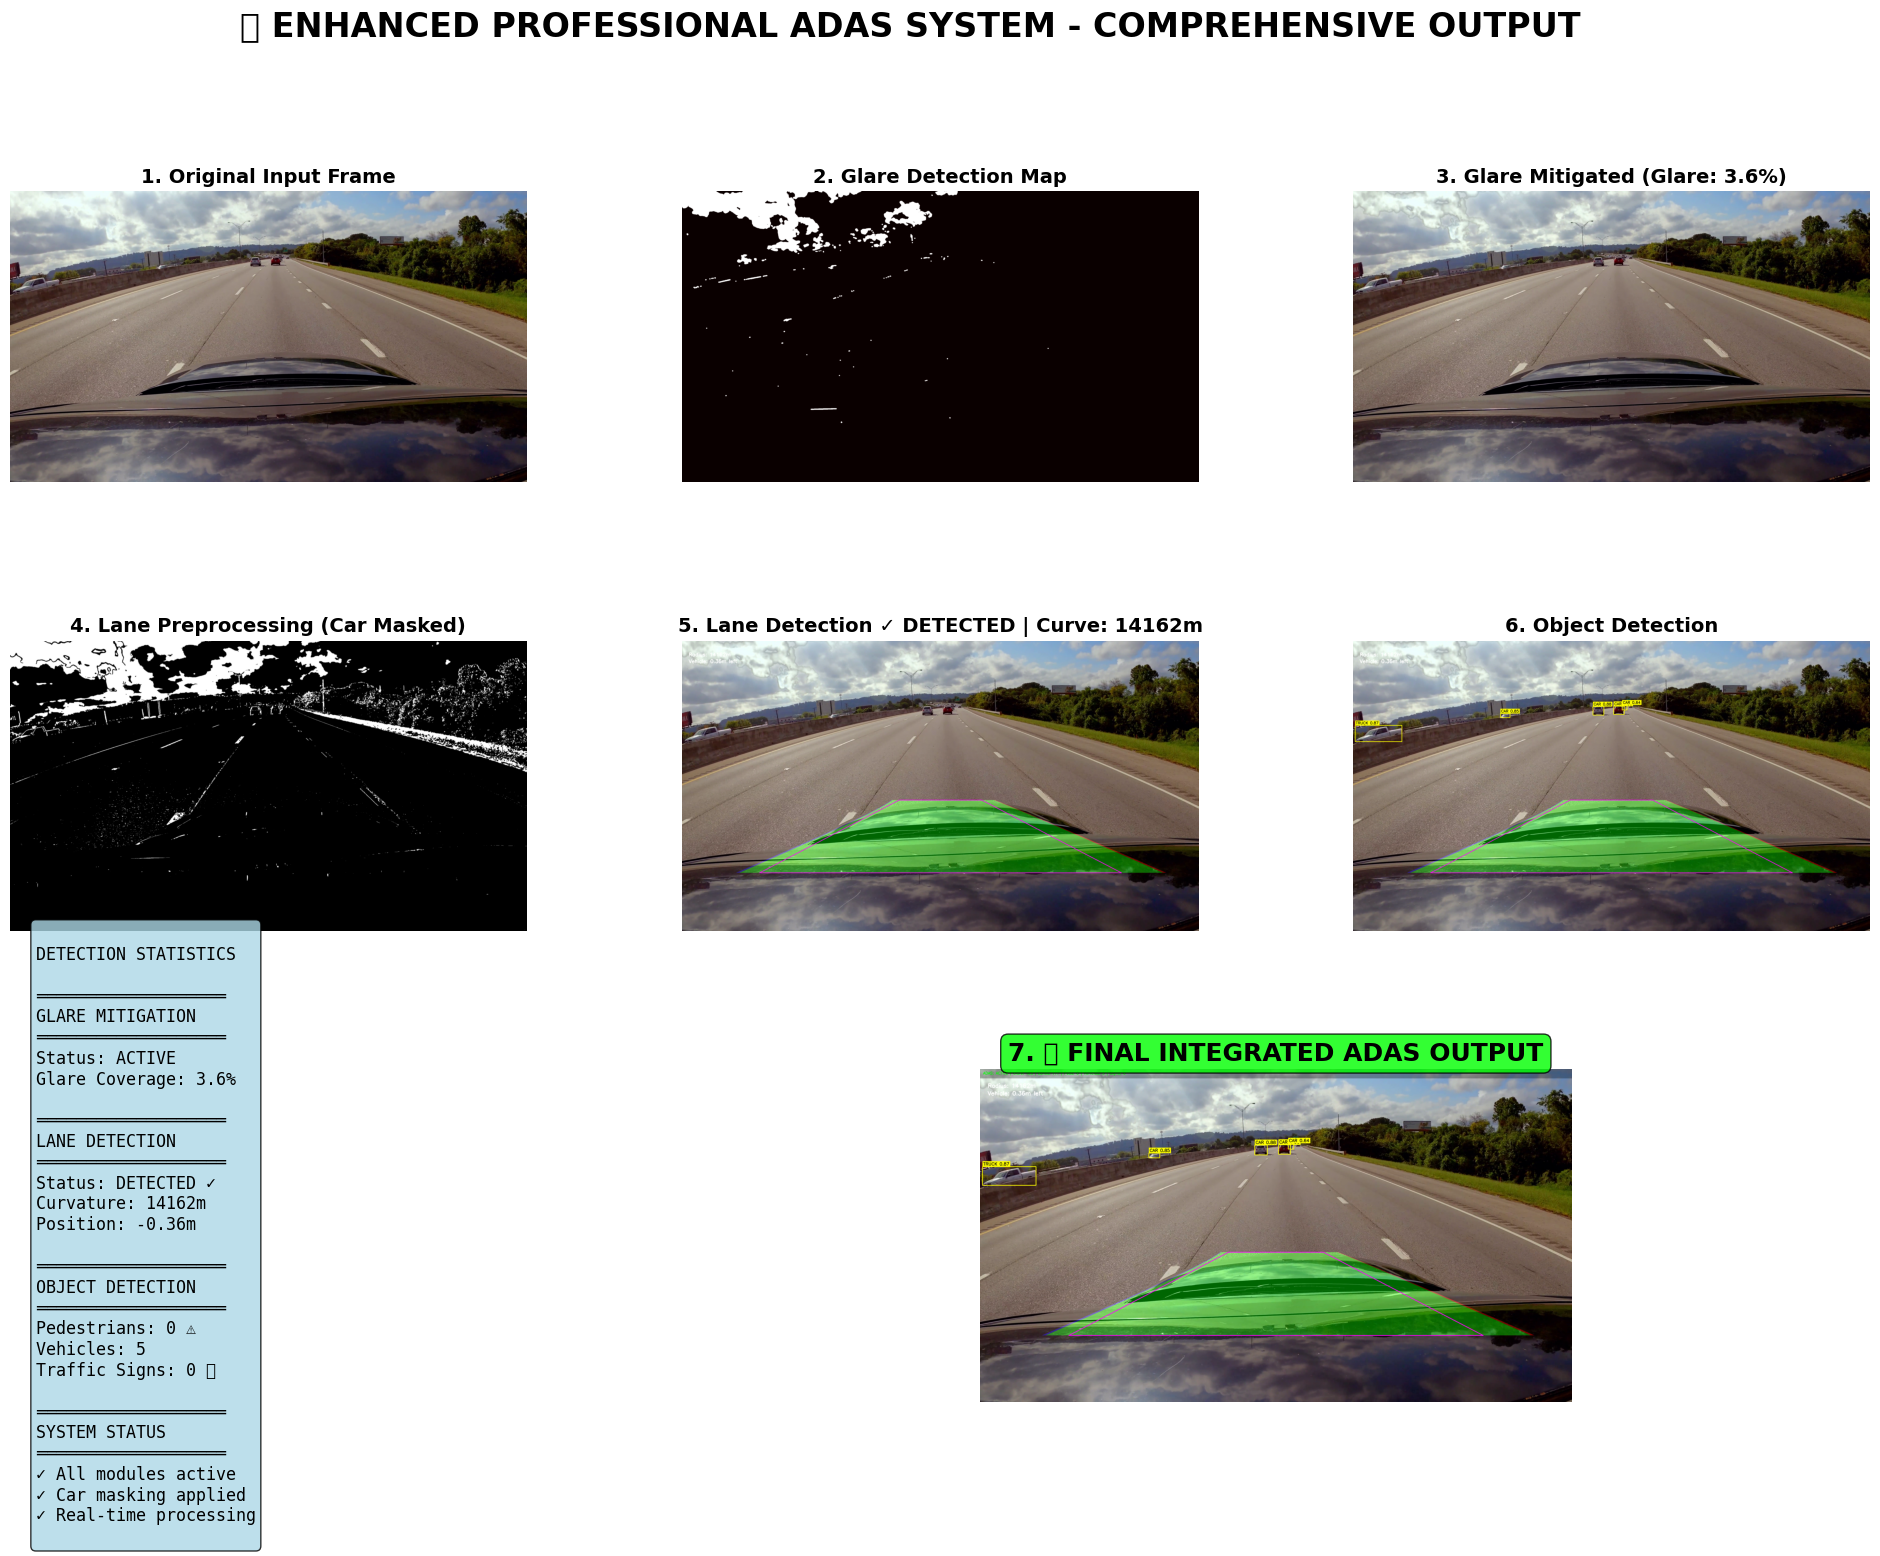



Showcase Frame 3 (Frame #120):


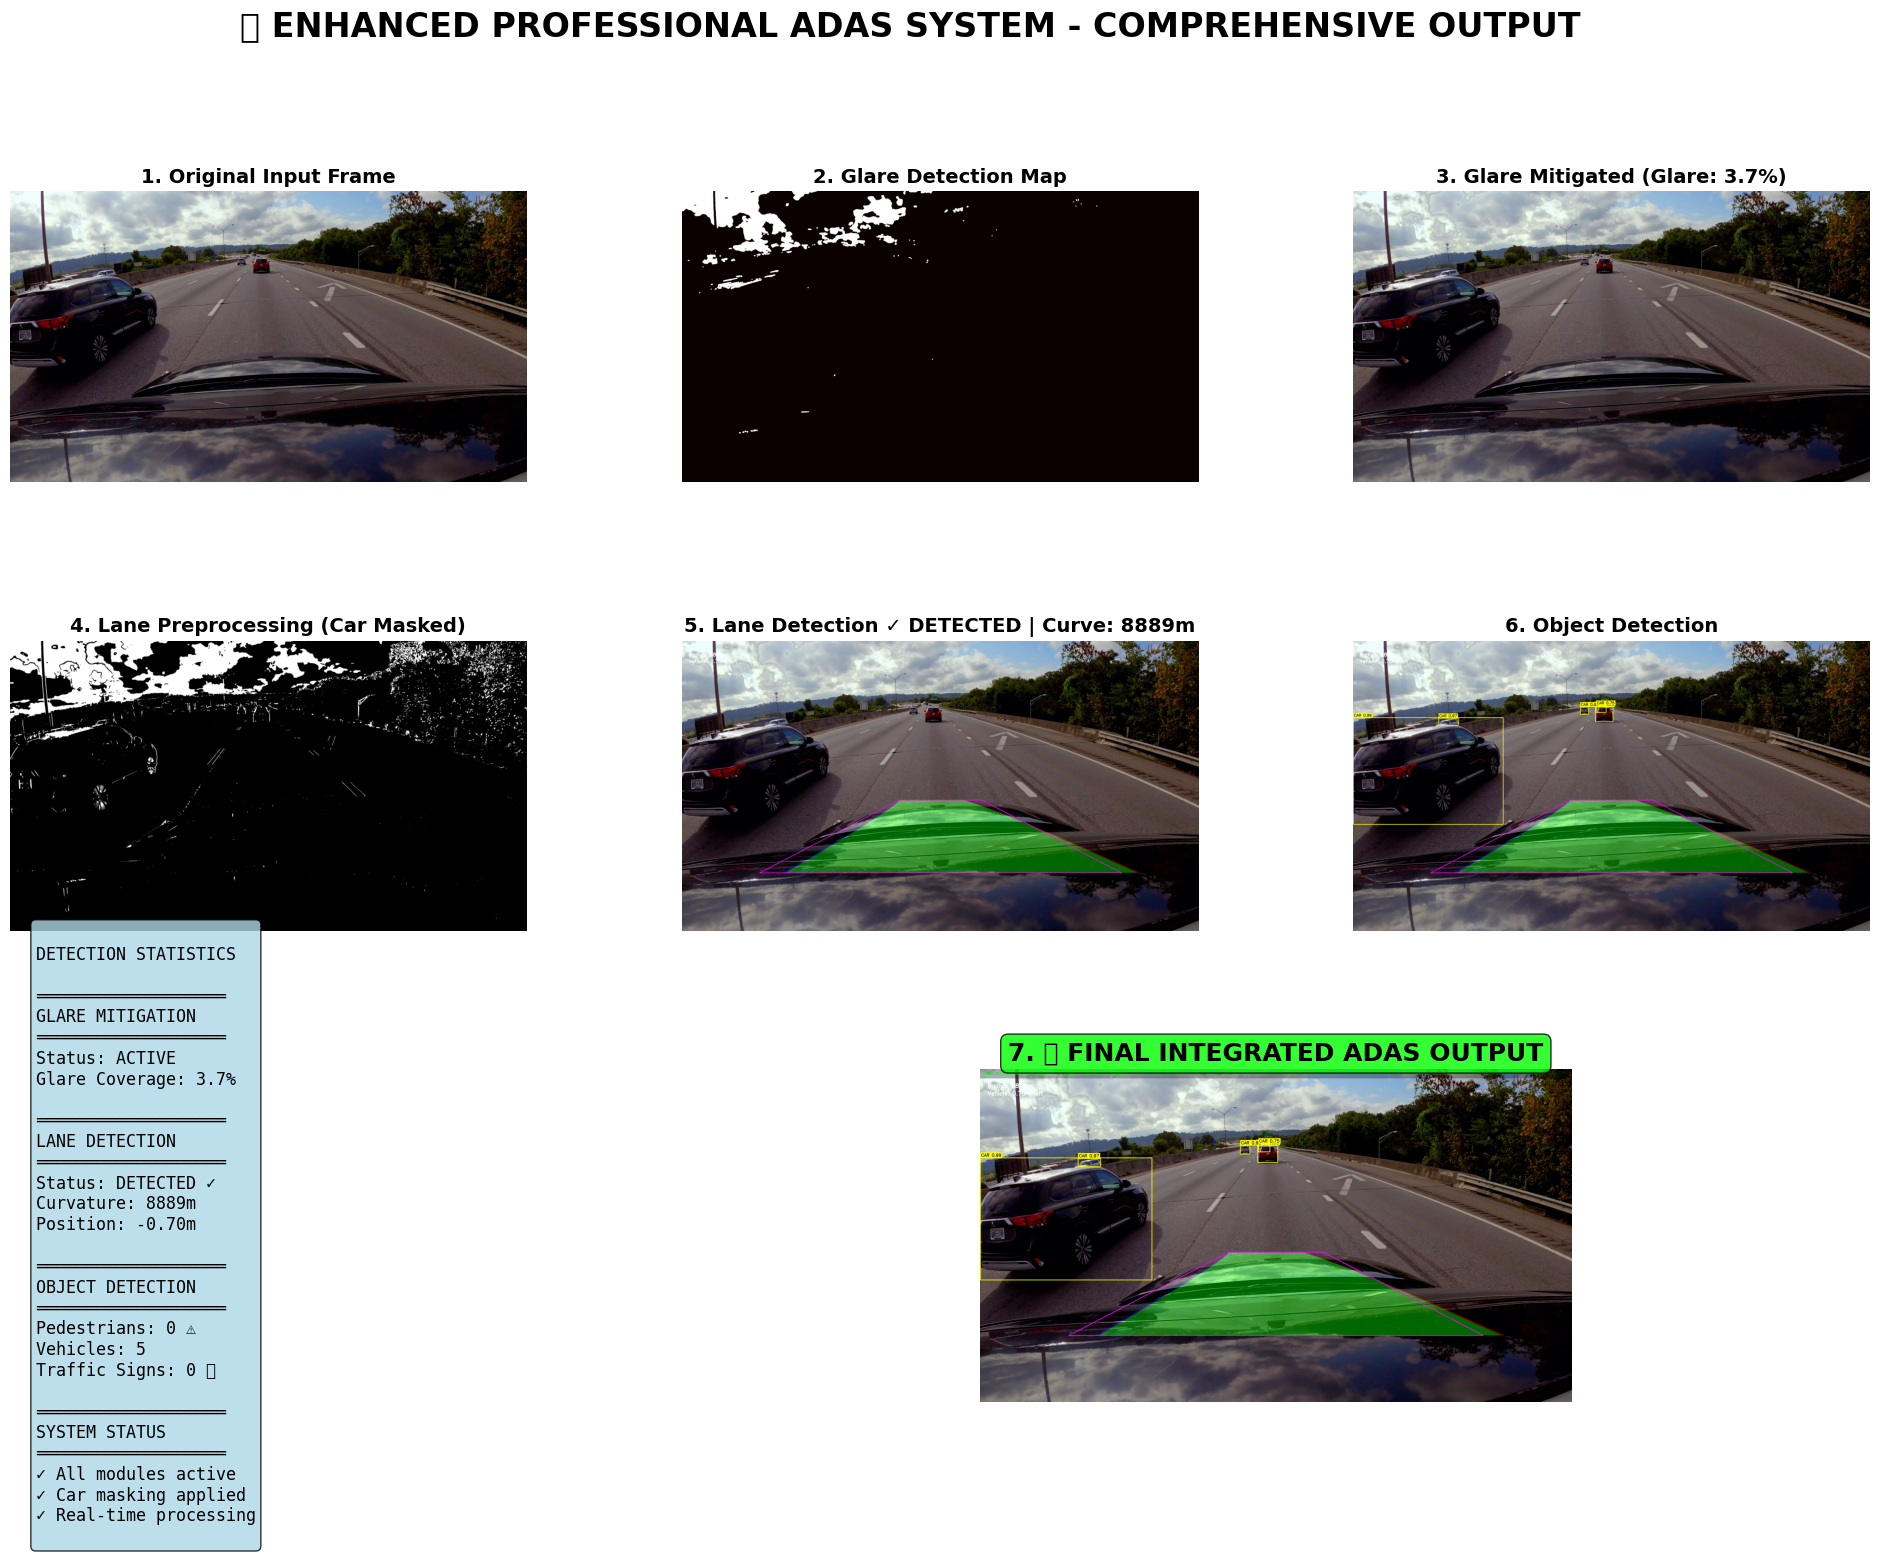



Showcase Frame 4 (Frame #180):


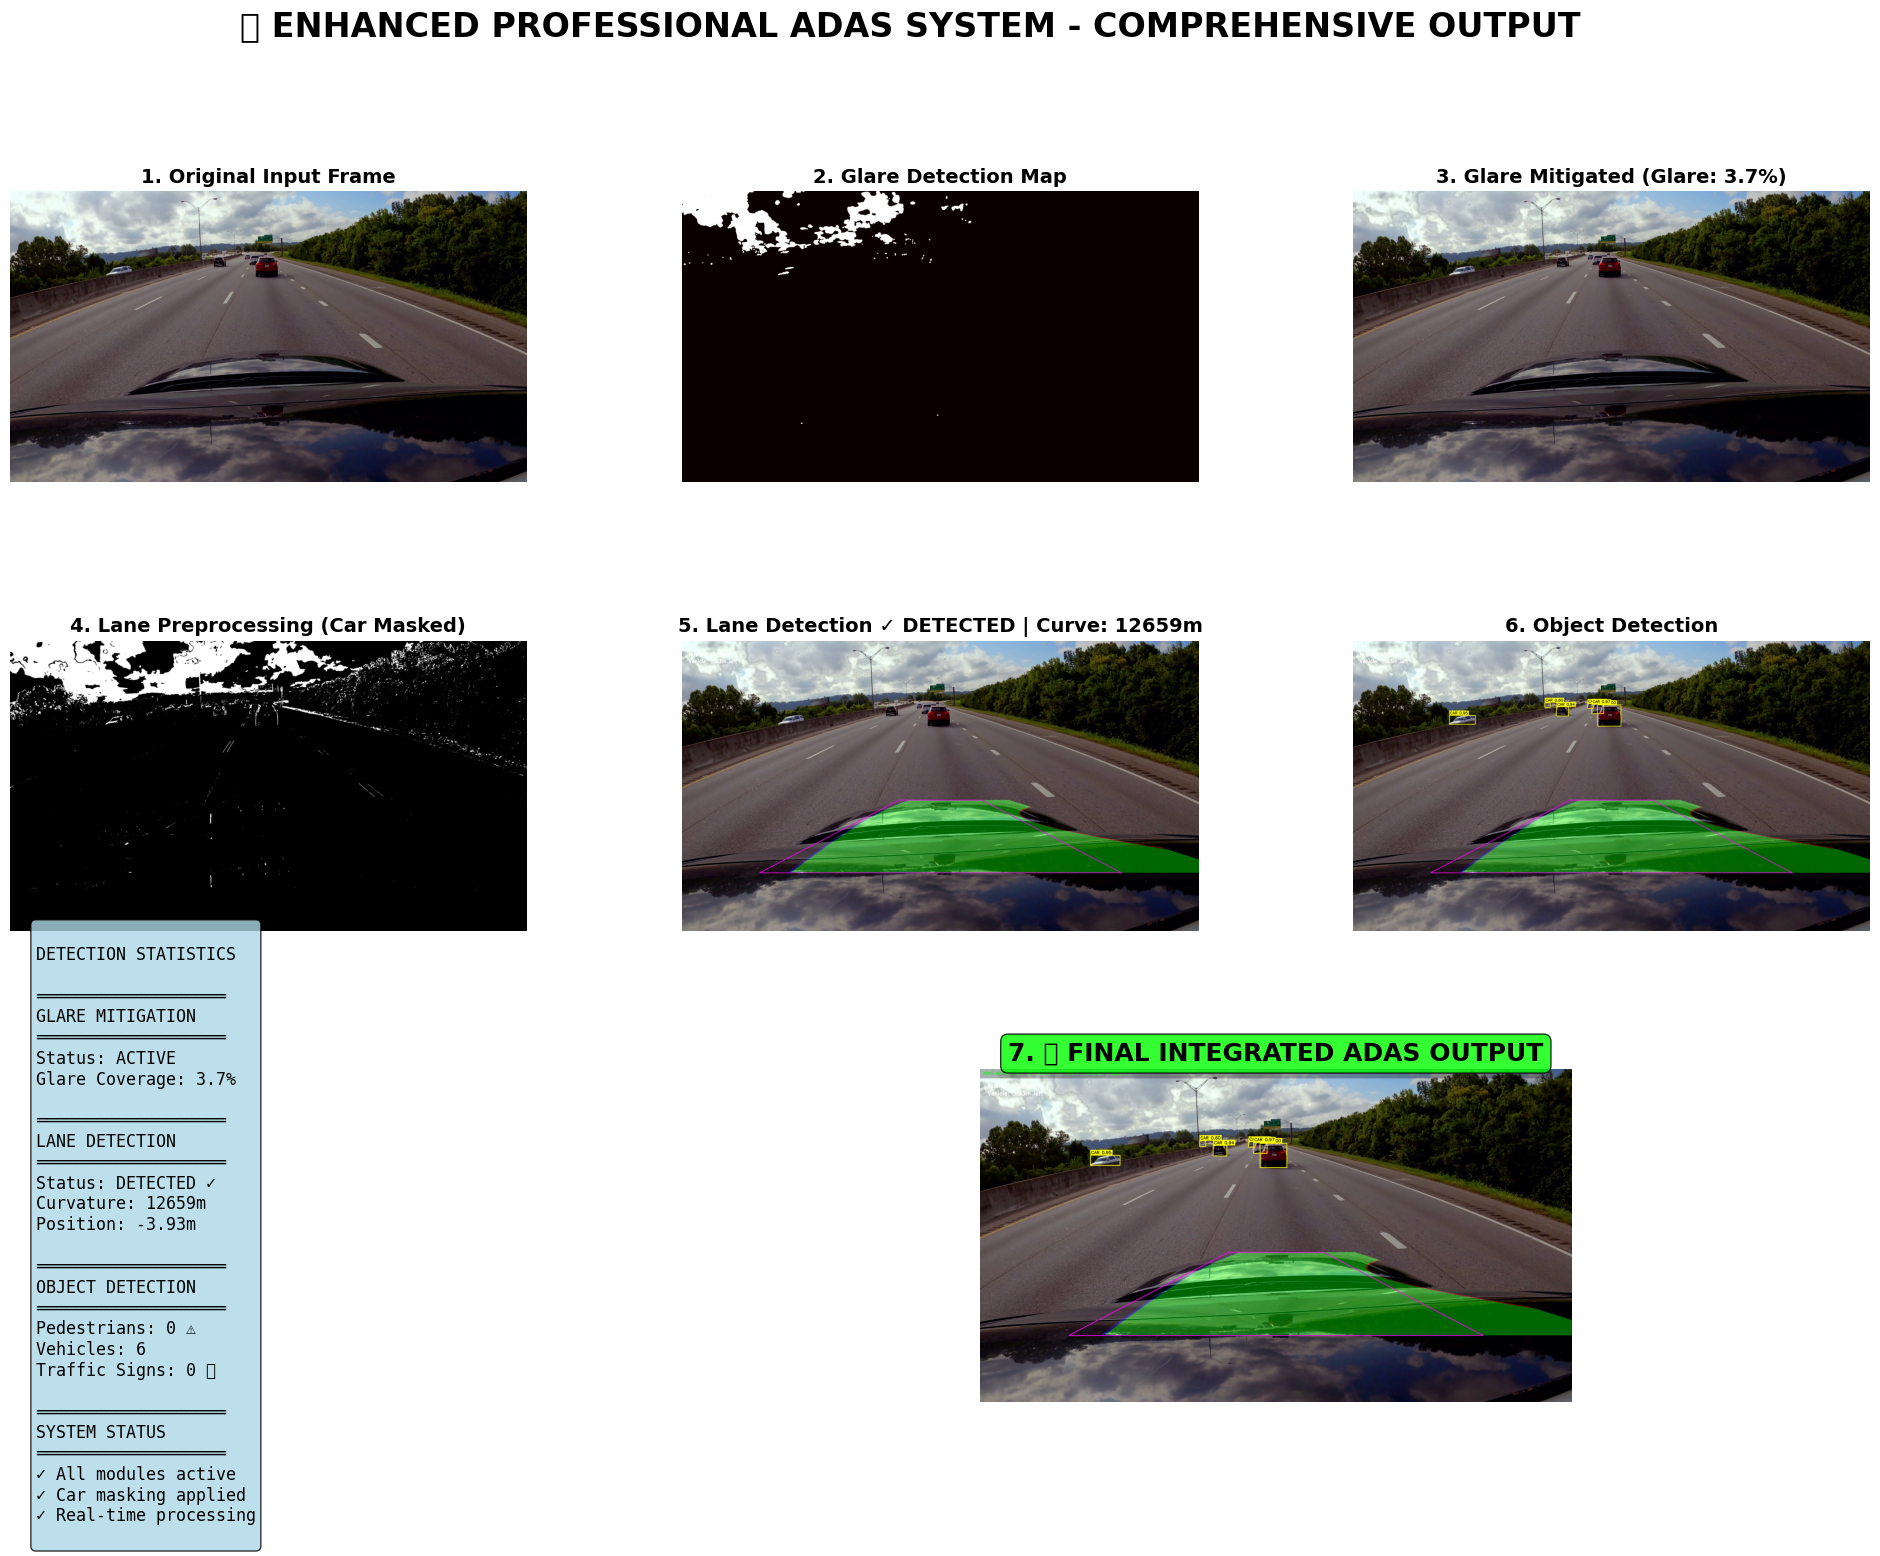



Showcase Frame 5 (Frame #240):


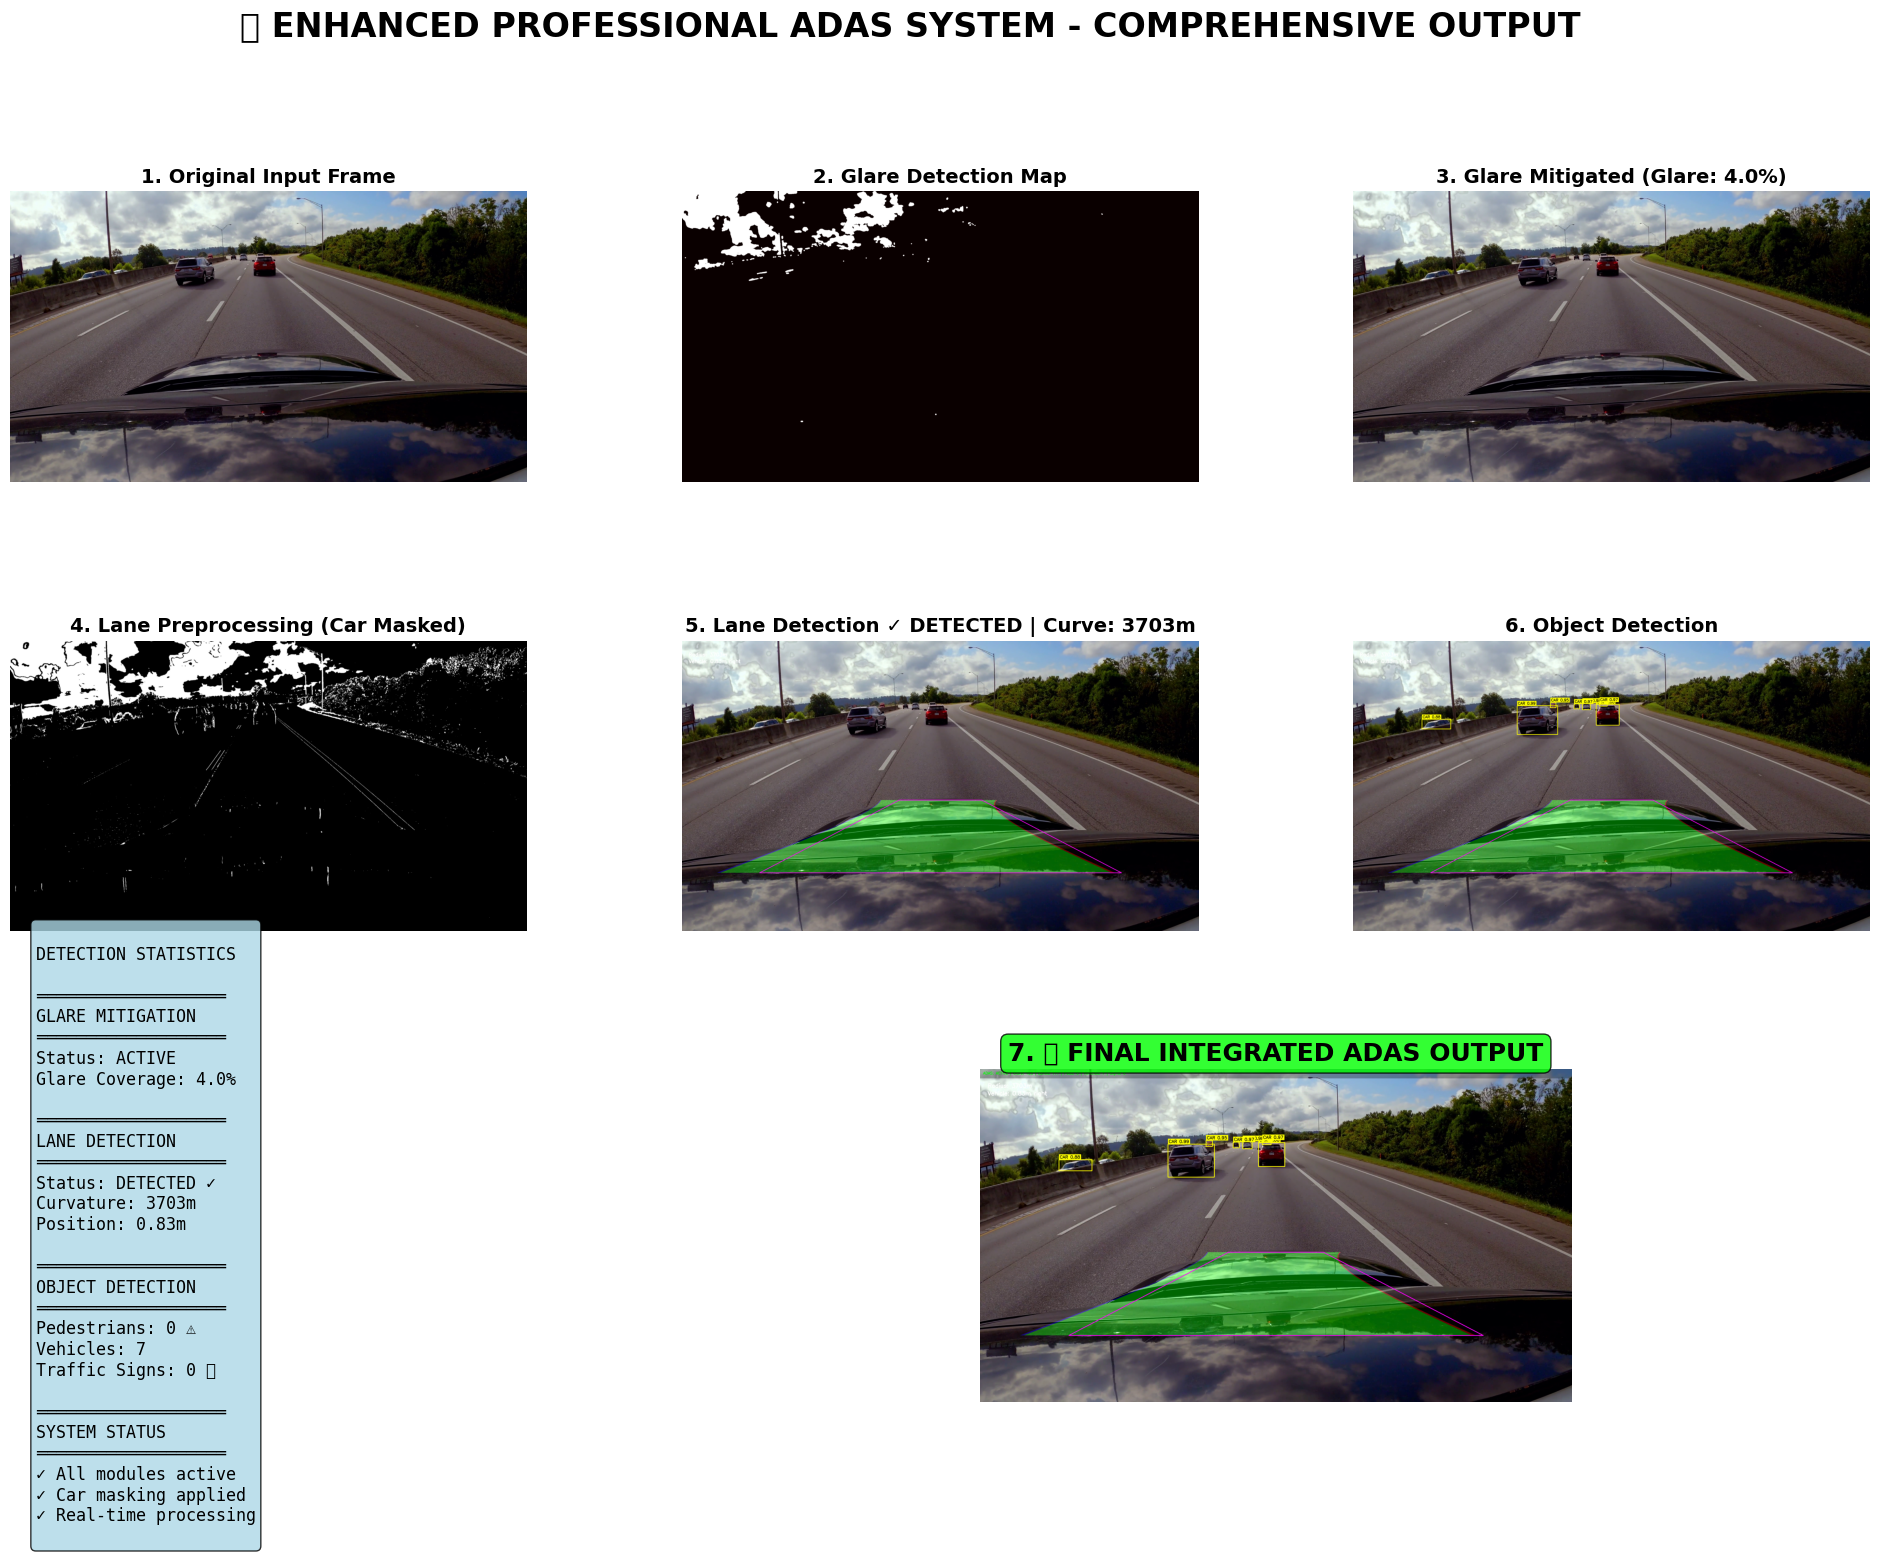



🎬 Displaying processed video in Colab...

Buffered data was truncated after reaching the output size limit.

In [ ]:
"""
ENHANCED PROFESSIONAL ADAS SYSTEM
Fixed lane detection with car masking and improved road focus
VIDEO PATH: /content/5382495-uhd_3840_2160_24fps.mp4
"""

import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import nms
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from IPython.display import HTML, display
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}\n")

# =====================================================
# 1. ENHANCED GLARE MITIGATION
# =====================================================

class EnhancedGlareMitigation:
    """Advanced glare detection and removal"""
    def __init__(self):
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def detect_glare_regions(self, image):
        """Multi-stage glare detection"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Stage 1: Extreme brightness
        _, extreme_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

        # Stage 2: High brightness with saturation check
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        _, bright_mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
        _, low_sat = cv2.threshold(hsv[:,:,1], 40, 255, cv2.THRESH_BINARY_INV)

        # Combine: bright + low saturation = glare
        glare_mask = cv2.bitwise_and(bright_mask, low_sat)
        glare_mask = cv2.bitwise_or(glare_mask, extreme_mask)

        # Morphological operations to refine
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        glare_mask = cv2.morphologyEx(glare_mask, cv2.MORPH_CLOSE, kernel)
        glare_mask = cv2.dilate(glare_mask, kernel, iterations=1)

        glare_percentage = (np.sum(glare_mask > 0) / glare_mask.size) * 100

        return glare_mask, glare_percentage

    def mitigate(self, image):
        """Advanced glare mitigation with multi-scale processing"""
        glare_mask, glare_pct = self.detect_glare_regions(image)

        if glare_pct > 0.5:  # Any glare detected
            # Convert to LAB for better color preservation
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to L channel
            l_enhanced = self.clahe.apply(l)

            # Bilateral filter to reduce glare while preserving edges
            l_filtered = cv2.bilateralFilter(l_enhanced, 9, 75, 75)

            # Merge back
            lab_enhanced = cv2.merge([l_filtered, a, b])
            enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

            # Inpaint glare regions for extreme cases
            if glare_pct > 5.0:
                glare_mask_uint8 = glare_mask.astype(np.uint8)
                enhanced = cv2.inpaint(enhanced, glare_mask_uint8, 3, cv2.INPAINT_TELEA)

            # Smooth blending
            glare_mask_3ch = cv2.cvtColor(glare_mask, cv2.COLOR_GRAY2BGR) / 255.0
            glare_mask_3ch = cv2.GaussianBlur(glare_mask_3ch, (15, 15), 0)

            result = (enhanced * glare_mask_3ch + image * (1 - glare_mask_3ch)).astype(np.uint8)

            return result, glare_mask, True, glare_pct

        return image, glare_mask, False, glare_pct

# =====================================================
# 2. ADVANCED LANE DETECTION WITH CAR MASKING
# =====================================================

class AdvancedLaneDetector:
    """Enhanced lane detection with robust car hood masking"""
    def __init__(self):
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.smoothing_frames = []
        self.max_smoothing = 5
        self.car_mask = None

    def create_car_mask(self, image_shape):
        """Create mask to exclude car hood from lane detection"""
        h, w = image_shape[:2]
        mask = np.ones((h, w), dtype=np.uint8) * 255

        # Define car hood region (bottom 15% of image + tapered sides)
        # This creates a trapezoid that covers the typical car hood area
        hood_height = int(h * 0.15)

        # Car hood polygon points (wider at bottom, narrower as it goes up)
        car_hood_pts = np.array([
            [0, h],                          # Bottom-left corner
            [w, h],                          # Bottom-right corner
            [int(w * 0.75), h - hood_height], # Top-right (tapered)
            [int(w * 0.25), h - hood_height]  # Top-left (tapered)
        ], dtype=np.int32)

        # Black out the car hood area
        cv2.fillPoly(mask, [car_hood_pts], 0)

        return mask

    def preprocess(self, image):
        """Multi-channel preprocessing with car masking"""
        # Convert to HLS
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        h, l, s = cv2.split(hls)

        # White lane detection (multiple methods)
        white_mask1 = cv2.inRange(l, 210, 255)

        # Convert to LAB
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_lab, a_lab, b_lab = cv2.split(lab)
        white_mask2 = cv2.inRange(l_lab, 200, 255)

        # Yellow lane detection
        yellow_mask = cv2.inRange(hls, np.array([10, 50, 100]), np.array([40, 255, 255]))

        # Combine all masks
        white_mask = cv2.bitwise_or(white_mask1, white_mask2)
        combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

        # Sobel edge detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        _, sobel_mask = cv2.threshold(scaled_sobel, 50, 255, cv2.THRESH_BINARY)

        # Combine with edge detection
        final_mask = cv2.bitwise_or(combined_mask, sobel_mask)

        # Apply car mask to exclude hood area
        if self.car_mask is None:
            self.car_mask = self.create_car_mask(image.shape)

        final_mask = cv2.bitwise_and(final_mask, self.car_mask)

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)

        # Gaussian blur
        blurred = cv2.GaussianBlur(final_mask, (5, 5), 0)

        return blurred

    def get_perspective_transform(self, image):
        """Optimized perspective transform - focuses on road only"""
        h, w = image.shape[:2]

        # ROI trapezoid - adjusted to avoid car hood completely
        # Start from 55% height (middle-upper area) to 80% height (above hood)
        src = np.float32([
            [w * 0.42, h * 0.55],  # Top-left (tighter)
            [w * 0.58, h * 0.55],  # Top-right (tighter)
            [w * 0.85, h * 0.80],  # Bottom-right (well above hood)
            [w * 0.15, h * 0.80]   # Bottom-left (well above hood)
        ])

        dst = np.float32([
            [w * 0.20, 0],
            [w * 0.80, 0],
            [w * 0.80, h],
            [w * 0.20, h]
        ])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

        return M, Minv, src

    def sliding_window_search(self, binary_warped):
        """Enhanced sliding window with better initialization"""
        # Take histogram of bottom half
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

        # Smooth histogram
        histogram = np.convolve(histogram, np.ones(20)/20, mode='same')

        if np.max(histogram) < 100:
            return None, None

        # Find peaks
        midpoint = len(histogram) // 2

        # Left lane base
        left_peak = np.argmax(histogram[:midpoint])
        # Right lane base
        right_peak = np.argmax(histogram[midpoint:]) + midpoint

        # Initialize
        nwindows = 12
        window_height = binary_warped.shape[0] // nwindows
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = left_peak
        rightx_current = right_peak
        margin = 80
        minpix = 40

        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                             (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit = None
        right_fit = None

        if len(leftx) > 500:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) > 500:
            right_fit = np.polyfit(righty, rightx, 2)

        # Temporal smoothing
        if left_fit is not None and right_fit is not None:
            self.smoothing_frames.append((left_fit, right_fit))
            if len(self.smoothing_frames) > self.max_smoothing:
                self.smoothing_frames.pop(0)

            # Average fits
            if len(self.smoothing_frames) > 1:
                left_fits = [f[0] for f in self.smoothing_frames]
                right_fits = [f[1] for f in self.smoothing_frames]
                left_fit = np.mean(left_fits, axis=0)
                right_fit = np.mean(right_fits, axis=0)

        return left_fit, right_fit

    def calculate_curvature(self, left_fit, right_fit, image_shape):
        """Calculate lane curvature and vehicle position"""
        h = image_shape[0]
        y_eval = h - 1

        # Meters per pixel
        ym_per_pix = 30 / 720
        xm_per_pix = 3.7 / 700

        if left_fit is not None and right_fit is not None:
            left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
            right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

            curvature = (left_curverad + right_curverad) / 2

            # Calculate vehicle position
            left_lane_pos = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
            right_lane_pos = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
            lane_center = (left_lane_pos + right_lane_pos) / 2
            vehicle_center = image_shape[1] / 2
            offset = (vehicle_center - lane_center) * xm_per_pix

            return curvature, offset

        return None, None

    def detect(self, image):
        """Main detection pipeline with car-masked visualization"""
        preprocessed = self.preprocess(image)
        M, Minv, src_points = self.get_perspective_transform(image)
        warped = cv2.warpPerspective(preprocessed, M, (image.shape[1], image.shape[0]))

        left_fit, right_fit = self.sliding_window_search(warped)

        result = image.copy()
        lane_overlay = np.zeros_like(image)
        lanes_detected = False
        curvature = None
        offset = None

        if left_fit is not None and right_fit is not None:
            lanes_detected = True
            h, w = image.shape[:2]

            # Only draw lanes in the ROI region (not over car)
            # Create y coordinates only for the ROI region
            roi_y_start = int(h * 0.55)
            roi_y_end = int(h * 0.80)
            ploty = np.linspace(0, roi_y_end - roi_y_start, roi_y_end - roi_y_start)

            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Create lane visualization
            warp_zero = np.zeros_like(warped).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

            # Adjust ploty for warped space
            ploty_full = np.linspace(0, h - 1, h)
            left_fitx_full = left_fit[0]*ploty_full**2 + left_fit[1]*ploty_full + left_fit[2]
            right_fitx_full = right_fit[0]*ploty_full**2 + right_fit[1]*ploty_full + right_fit[2]

            # Create filled polygon
            pts_left = np.array([np.transpose(np.vstack([left_fitx_full, ploty_full]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_full, ploty_full])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw filled lane area (green with transparency)
            cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

            # Draw lane boundaries (thick lines)
            for i in range(len(ploty_full) - 1):
                cv2.line(color_warp,
                        (int(left_fitx_full[i]), int(ploty_full[i])),
                        (int(left_fitx_full[i+1]), int(ploty_full[i+1])),
                        (255, 0, 0), 20)  # Blue for left
                cv2.line(color_warp,
                        (int(right_fitx_full[i]), int(ploty_full[i])),
                        (int(right_fitx_full[i+1]), int(ploty_full[i+1])),
                        (0, 0, 255), 20)  # Red for right

            # Unwarp back to original perspective
            newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))

            # Apply car mask to the lane overlay to prevent overlap
            if self.car_mask is None:
                self.car_mask = self.create_car_mask(image.shape)
            car_mask_3ch = cv2.cvtColor(self.car_mask, cv2.COLOR_GRAY2BGR)
            newwarp = cv2.bitwise_and(newwarp, car_mask_3ch)

            result = cv2.addWeighted(image, 1, newwarp, 0.4, 0)

            # Calculate curvature and offset
            curvature, offset = self.calculate_curvature(left_fit, right_fit, image.shape)

            # Add text information (positioned higher to avoid car)
            if curvature is not None:
                curve_text = f"Radius: {curvature:.0f}m"
                cv2.putText(result, curve_text, (50, 120),
                          cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

            if offset is not None:
                if offset > 0:
                    position_text = f"Vehicle: {abs(offset):.2f}m right"
                else:
                    position_text = f"Vehicle: {abs(offset):.2f}m left"
                cv2.putText(result, position_text, (50, 170),
                          cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

        # Draw ROI trapezoid (only the detection area, not over car)
        cv2.polylines(result, [src_points.astype(np.int32)], True, (255, 0, 255), 3)

        return result, lanes_detected, preprocessed, curvature, offset

# =====================================================
# 3. ENHANCED OBJECT DETECTION
# =====================================================

class EnhancedObjectDetector:
    """Enhanced Faster R-CNN with better filtering"""
    def __init__(self, confidence_threshold=0.6):
        print("⏳ Loading object detection model...")
        self.model = fasterrcnn_resnet50_fpn(pretrained=True)
        self.model.to(device)
        self.model.eval()
        self.confidence_threshold = confidence_threshold
        print("✓ Object detection ready\n")

        self.COCO_CLASSES = {
            1: 'person',
            2: 'bicycle',
            3: 'car',
            4: 'motorcycle',
            5: 'airplane',
            6: 'bus',
            7: 'train',
            8: 'truck',
            10: 'traffic light',
            11: 'fire hydrant',
            12: 'stop sign',
            13: 'parking meter'
        }

    def detect(self, image):
        """Enhanced detection with NMS and filtering"""
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            predictions = self.model([img_tensor])[0]

        result = image.copy()
        pedestrians = []
        vehicles = []
        traffic_signs = []

        boxes = predictions['boxes'].cpu()
        labels = predictions['labels'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()

        # Apply NMS
        keep_indices = nms(boxes, torch.from_numpy(scores), 0.3).numpy()

        for idx in keep_indices:
            score = scores[idx]
            label = labels[idx]

            if score > self.confidence_threshold and label in self.COCO_CLASSES:
                box = boxes[idx].numpy().astype(int)
                x1, y1, x2, y2 = box
                class_name = self.COCO_CLASSES[label]

                # Filter small boxes
                box_area = (x2 - x1) * (y2 - y1)
                if box_area < 1000:
                    continue

                # Pedestrians (RED)
                if label == 1:
                    color = (0, 0, 255)
                    thickness = 5
                    cv2.rectangle(result, (x1, y1), (x2, y2), color, thickness)

                    label_text = f'⚠ PEDESTRIAN {score:.2f}'
                    (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)
                    cv2.rectangle(result, (x1, y1-th-15), (x1+tw+10, y1), color, -1)
                    cv2.putText(result, label_text, (x1+5, y1-8),
                              cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
                    pedestrians.append((x1, y1, x2-x1, y2-y1, score))

                # Vehicles (YELLOW)
                elif label in [2, 3, 4, 5, 6, 7, 8]:
                    color = (0, 255, 255)
                    thickness = 4
                    cv2.rectangle(result, (x1, y1), (x2, y2), color, thickness)

                    label_text = f'{class_name.upper()} {score:.2f}'
                    (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                    cv2.rectangle(result, (x1, y1-th-15), (x1+tw+10, y1), color, -1)
                    cv2.putText(result, label_text, (x1+5, y1-8),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                    vehicles.append((x1, y1, x2-x1, y2-y1, class_name, score))

                # Traffic signs and lights (MAGENTA)
                elif label in [10, 11, 12, 13]:
                    color = (255, 0, 255)
                    thickness = 5
                    cv2.rectangle(result, (x1, y1), (x2, y2), color, thickness)

                    label_text = f'🚦 {class_name.upper()} {score:.2f}'
                    (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                    cv2.rectangle(result, (x1, y1-th-15), (x1+tw+10, y1), color, -1)
                    cv2.putText(result, label_text, (x1+5, y1-8),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    traffic_signs.append((x1, y1, x2-x1, y2-y1, class_name, score))

        return result, pedestrians, vehicles, traffic_signs

# =====================================================
# INTEGRATED ENHANCED ADAS SYSTEM
# =====================================================

class EnhancedADAS:
    def __init__(self):
        print("="*80)
        print("🚗 ENHANCED PROFESSIONAL ADAS SYSTEM INITIALIZATION")
        print("="*80)
        self.glare_mitigator = EnhancedGlareMitigation()
        print("✓ Glare mitigation loaded")
        self.lane_detector = AdvancedLaneDetector()
        print("✓ Lane detector loaded")
        self.object_detector = EnhancedObjectDetector()
        print("="*80)
        print("✅ ALL SYSTEMS READY!")
        print("="*80 + "\n")

    def process_frame(self, frame):
        """Process single frame through all modules"""
        results = {}

        # 1. Glare Mitigation
        deglared, glare_mask, has_glare, glare_pct = self.glare_mitigator.mitigate(frame)
        results['original'] = frame
        results['deglared'] = deglared
        results['glare_mask'] = glare_mask
        results['has_glare'] = has_glare
        results['glare_pct'] = glare_pct

        # 2. Lane Detection
        lanes_img, lanes_detected, lane_preprocess, curvature, offset = self.lane_detector.detect(deglared)
        results['lanes'] = lanes_img
        results['lanes_detected'] = lanes_detected
        results['lane_preprocess'] = lane_preprocess
        results['curvature'] = curvature
        results['offset'] = offset

        # 3. Object Detection
        objects_img, pedestrians, vehicles, signs = self.object_detector.detect(lanes_img)
        results['objects'] = objects_img
        results['pedestrians'] = len(pedestrians)
        results['vehicles'] = len(vehicles)
        results['traffic_signs'] = len(signs)

        # 4. Add status overlay
        final = objects_img.copy()

        # Status panel
        panel_height = 60
        overlay = final.copy()
        cv2.rectangle(overlay, (0, 0), (final.shape[1], panel_height), (0, 0, 0), -1)
        final = cv2.addWeighted(final, 0.7, overlay, 0.3, 0)

        # Status text
        status_text = f"ADAS: ACTIVE | Glare: {'YES' if has_glare else 'NO'} | Lanes: {'✓' if lanes_detected else '✗'} | Peds: {results['pedestrians']} | Vehicles: {results['vehicles']} | Signs: {results['traffic_signs']}"
        cv2.putText(final, status_text, (20, 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        results['final'] = final

        return results

    def create_showcase_visualization(self, results):
        """Create comprehensive visualization"""
        fig = plt.figure(figsize=(24, 16))
        gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

        fig.suptitle('🚗 ENHANCED PROFESSIONAL ADAS SYSTEM - COMPREHENSIVE OUTPUT',
                    fontsize=24, fontweight='bold', y=0.98)

        # Row 1: Glare Processing
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
        ax1.set_title('1. Original Input Frame', fontsize=14, fontweight='bold')
        ax1.axis('off')

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(results['glare_mask'], cmap='hot')
        ax2.set_title('2. Glare Detection Map', fontsize=14, fontweight='bold')
        ax2.axis('off')

        ax3 = fig.add_subplot(gs[0, 2])
        ax3.imshow(cv2.cvtColor(results['deglared'], cv2.COLOR_BGR2RGB))
        glare_status = f"Glare: {results['glare_pct']:.1f}%" if results['has_glare'] else "No Glare Detected"
        ax3.set_title(f'3. Glare Mitigated ({glare_status})', fontsize=14, fontweight='bold')
        ax3.axis('off')

        # Row 2: Lane Detection
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.imshow(results['lane_preprocess'], cmap='gray')
        ax4.set_title('4. Lane Preprocessing (Car Masked)', fontsize=14, fontweight='bold')
        ax4.axis('off')

        ax5 = fig.add_subplot(gs[1, 1])
        ax5.imshow(cv2.cvtColor(results['lanes'], cv2.COLOR_BGR2RGB))
        lane_status = "✓ DETECTED" if results['lanes_detected'] else "✗ NOT DETECTED"
        if results['curvature']:
            lane_status += f" | Curve: {results['curvature']:.0f}m"
        ax5.set_title(f'5. Lane Detection {lane_status}', fontsize=14, fontweight='bold')
        ax5.axis('off')

        ax6 = fig.add_subplot(gs[1, 2])
        ax6.imshow(cv2.cvtColor(results['objects'], cv2.COLOR_BGR2RGB))
        ax6.set_title('6. Object Detection', fontsize=14, fontweight='bold')
        ax6.axis('off')

        # Row 3: Statistics and Final
        ax7 = fig.add_subplot(gs[2, 0])
        stats_text = f"""
DETECTION STATISTICS

═══════════════════
GLARE MITIGATION
═══════════════════
Status: {'ACTIVE' if results['has_glare'] else 'INACTIVE'}
Glare Coverage: {results['glare_pct']:.1f}%

═══════════════════
LANE DETECTION
═══════════════════
Status: {'DETECTED ✓' if results['lanes_detected'] else 'NOT DETECTED ✗'}
Curvature: {f"{results['curvature']:.0f}m" if results['curvature'] else 'N/A'}
Position: {f"{results['offset']:.2f}m" if results['offset'] else 'N/A'}

═══════════════════
OBJECT DETECTION
═══════════════════
Pedestrians: {results['pedestrians']} ⚠
Vehicles: {results['vehicles']}
Traffic Signs: {results['traffic_signs']} 🚦

═══════════════════
SYSTEM STATUS
═══════════════════
✓ All modules active
✓ Car masking applied
✓ Real-time processing
        """
        ax7.text(0.05, 0.5, stats_text, fontsize=12, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        ax7.axis('off')

        ax8 = fig.add_subplot(gs[2, 1:])
        ax8.imshow(cv2.cvtColor(results['final'], cv2.COLOR_BGR2RGB))
        ax8.set_title('7. ✅ FINAL INTEGRATED ADAS OUTPUT', fontsize=18, fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8))
        ax8.axis('off')

        plt.tight_layout()
        return fig

    def process_video_with_showcase(self, video_path, max_frames=300, showcase_interval=50):
        """Process video and show periodic showcases"""
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"❌ Could not open video: {video_path}")
            return None

        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Video Information:")
        print(f"   Path: {video_path}")
        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps}")
        print(f"   Total frames: {total_frames}")
        print(f"   Processing: {min(max_frames, total_frames)} frames\n")

        # Output video writer
        output_path = 'output_enhanced_adas.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        stats = {
            'glare': 0,
            'lanes': 0,
            'pedestrians': 0,
            'vehicles': 0,
            'signs': 0,
            'total_glare_pct': 0
        }
        showcase_frames = []

        print("🔄 Processing video frames...")
        print("─" * 80)

        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            results = self.process_frame(frame)

            # Write output
            out.write(results['final'])

            # Update stats
            if results['has_glare']:
                stats['glare'] += 1
                stats['total_glare_pct'] += results['glare_pct']
            if results['lanes_detected']:
                stats['lanes'] += 1
            stats['pedestrians'] += results['pedestrians']
            stats['vehicles'] += results['vehicles']
            stats['signs'] += results['traffic_signs']

            # Save showcase frames
            if frame_count % showcase_interval == 0:
                showcase_frames.append(results)

            frame_count += 1

            # Progress indicator
            if frame_count % 25 == 0:
                progress = (frame_count / max_frames) * 100
                print(f"   ⏳ Progress: {frame_count}/{max_frames} frames ({progress:.1f}%) | "
                      f"Lanes: {stats['lanes']} | Peds: {stats['pedestrians']} | "
                      f"Vehicles: {stats['vehicles']} | Signs: {stats['signs']}")

        cap.release()
        out.release()

        print("─" * 80)
        print("\n" + "="*80)
        print("✅ VIDEO PROCESSING COMPLETE!")
        print("="*80)
        print(f"📊 COMPREHENSIVE STATISTICS:")
        print(f"   Total frames processed: {frame_count}")
        print(f"   Frames with glare: {stats['glare']} ({stats['glare']/frame_count*100:.1f}%)")
        if stats['glare'] > 0:
            avg_glare = stats['total_glare_pct'] / stats['glare']
            print(f"   Average glare coverage: {avg_glare:.1f}%")
        print(f"   Frames with lanes detected: {stats['lanes']} ({stats['lanes']/frame_count*100:.1f}%)")
        print(f"   Total pedestrians detected: {stats['pedestrians']}")
        print(f"   Total vehicles detected: {stats['vehicles']}")
        print(f"   Total traffic signs detected: {stats['signs']}")
        print(f"   Output saved to: {output_path}")
        print("="*80 + "\n")

        # Show showcases
        print("📸 Displaying sample frame showcases...")
        print("─" * 80 + "\n")

        num_showcases = min(5, len(showcase_frames))
        for i, results in enumerate(showcase_frames[:num_showcases]):
            print(f"Showcase Frame {i+1} (Frame #{i*showcase_interval}):")
            fig = self.create_showcase_visualization(results)
            plt.show()
            print("\n")

        # Display video
        print("🎬 Displaying processed video in Colab...\n")
        self.display_video_in_colab(output_path)

        return stats, output_path

    def display_video_in_colab(self, video_path):
        """Display video directly in Colab notebook"""
        if not os.path.exists(video_path):
            print(f"❌ Video file not found: {video_path}")
            return

        try:
            with open(video_path, 'rb') as f:
                mp4 = f.read()

            data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

            display(HTML(f"""
            <div style="text-align: center; padding: 20px;">
                <h2>🎬 Enhanced ADAS Output Video</h2>
                <video width="1000" controls autoplay loop>
                    <source src="{data_url}" type="video/mp4">
                    Your browser does not support the video tag.
                </video>
                <p style="margin-top: 10px; color: #666;">
                    Video size: {len(mp4) / (1024*1024):.2f} MB
                </p>
            </div>
            """))

            print(f"✅ Video displayed successfully!")
            print(f"   File size: {len(mp4) / (1024*1024):.2f} MB")

        except Exception as e:
            print(f"❌ Error displaying video: {str(e)}")
            print(f"   You can download the video from: {video_path}")

# =====================================================
# MAIN EXECUTION
# =====================================================

if __name__ == "__main__":
    print("\n" + "🎬 STARTING ENHANCED PROFESSIONAL ADAS DEMO" + "\n")
    print("="*80)

    video_path = '/content/5382495-uhd_3840_2160_24fps.mp4'

    if os.path.exists(video_path):
        print(f"✓ Video file found: {video_path}\n")

        # Initialize Enhanced ADAS
        adas = EnhancedADAS()

        # Process video with showcases
        stats, output_path = adas.process_video_with_showcase(
            video_path,
            max_frames=300,  # Process first 300 frames (~12 seconds at 24fps)
            showcase_interval=60  # Show showcase every 60 frames
        )

        print("\n" + "="*80)
        print("🎉 ENHANCED ADAS DEMO COMPLETE!")
        print("="*80)
        print(f"\n💾 Output video saved to: {output_path}")
        print(f"   You can download it using the Colab files panel")
        print("\n" + "="*80)

    else:
        print(f"❌ Video file not found: {video_path}")
        print("\nPlease ensure the video is uploaded to /content/ directory")
        print("You can upload it using:")
        print("1. Colab files panel (folder icon on left)")
        print("2. Or use: from google.colab import files; files.upload()")